# Test GIA functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import xarray as xr

import cartopy.feature as cfeature
import cartopy.crs as ccrs

import regionmask

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

## Ice6G

In [3]:
data_dir = '../../Data_Proj/'
DIR_GIA = data_dir+'GIA/ICE-6G_VM5a/'

In [4]:
# Read GIA map
gia = xr.open_dataset(DIR_GIA+'dsea.1grid_O512.nc').sortby("Lat")

In [5]:
gia

<xarray.Dataset>
Dimensions:   (Lon: 360, Lat: 180)
Coordinates:
  * Lon       (Lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * Lat       (Lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    Dsea_250  (Lat, Lon) float32 ...
Attributes:
    title:    IceModel=ICE-6G_C,  Viscosity=VM5a,  Resolution=O(512)
    Author:   W.R. Peltier, Dept of Physics, Univ of Toronto, Canada
    Request:  Please cite the following papers. PAPER1 describes the new Anta...
    PAPER1:   Argus, D.F., Peltier, W.R., Drummond, R. and Moore, A.W.(2014) ...
    PAPER2:   Peltier, W.R., Argus, D.F. and Drummond, R.(2015) Space geodesy...
    history:  created: 2015, 4/ 1 14:48  by program create_netcdf

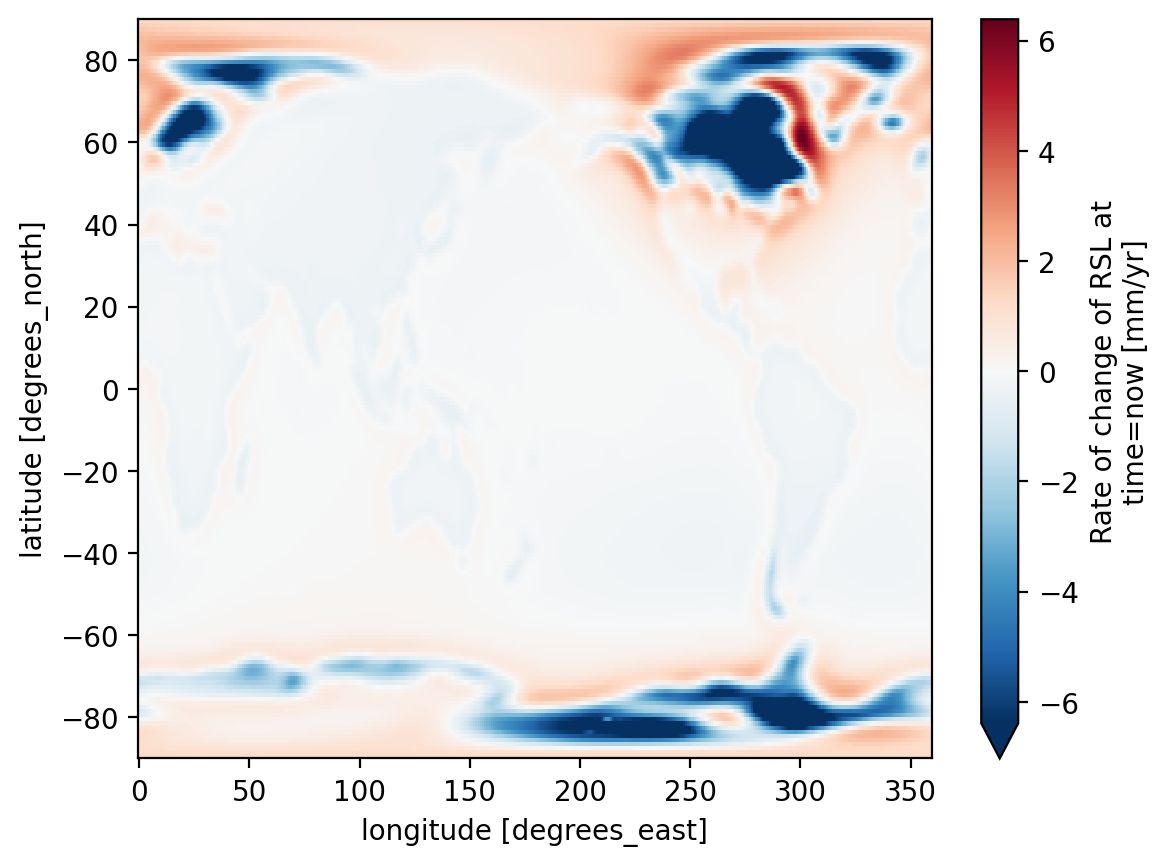

In [6]:
gia.Dsea_250.plot(robust=True)

## Dutch coast

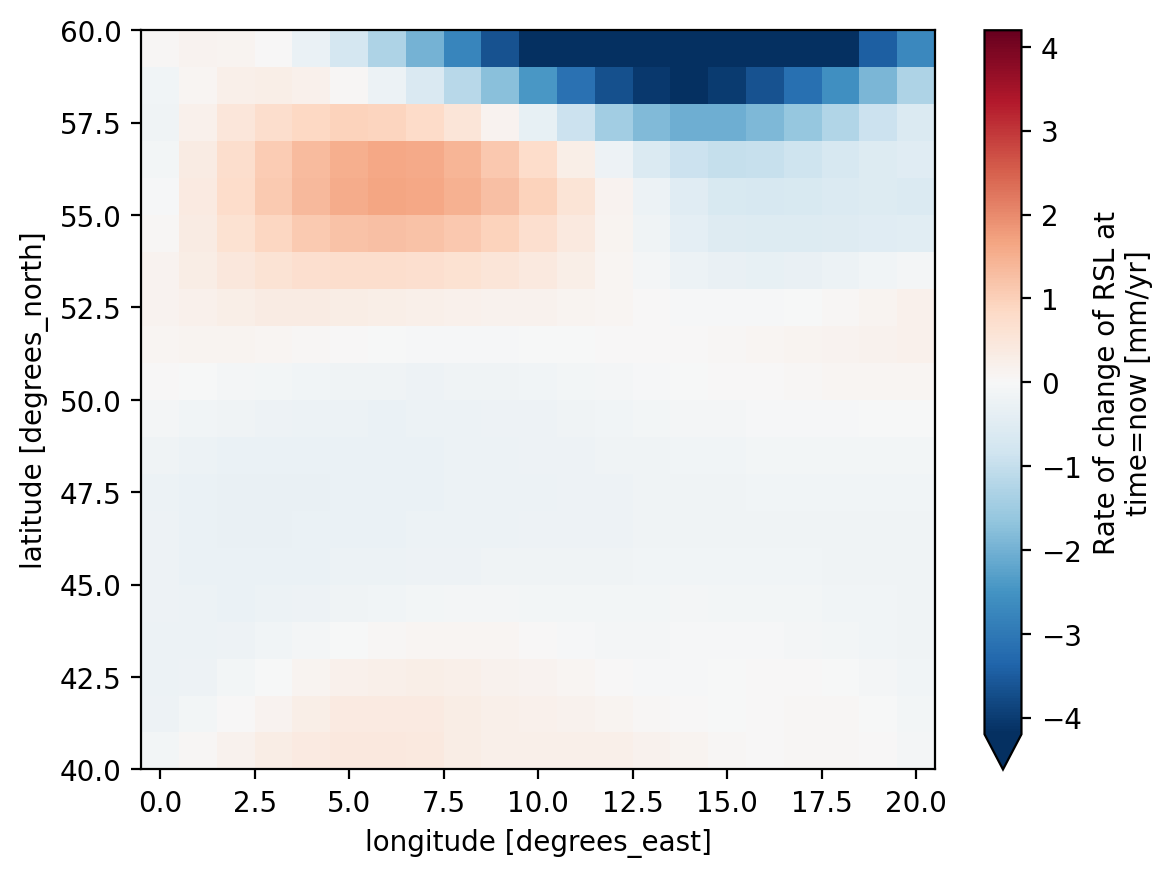

In [7]:
gia.Dsea_250.sel(Lat=slice(40,60), Lon=slice(0,20) ).plot(robust=True)

Text(0.5, 1.0, 'Current GIA')

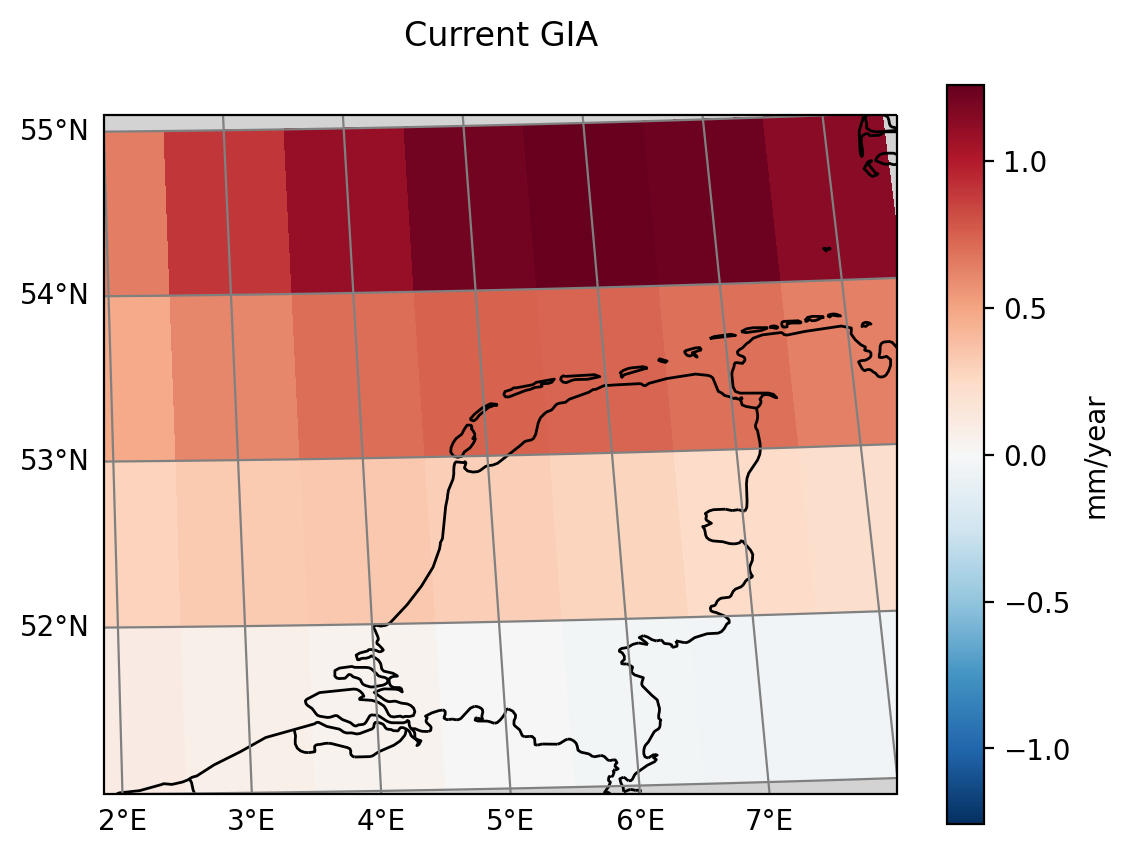

In [9]:
lon_min, lon_max, lat_min, lat_max = 2, 8, 51, 55

p = gia.Dsea_250.sel(Lat=slice(lat_min,lat_max), Lon=slice(lon_min,lon_max) ).plot(
    subplot_kws=dict(projection=ccrs.LambertAzimuthalEqualArea(), facecolor='lightgray'), 
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'label':'mm/year'},
    #robust=True,
    zorder=0)

#p.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
p.axes.add_feature(cfeature.BORDERS)
p.axes.coastlines()

#NLregion.plot(add_label=False)

gl = p.axes.gridlines(color='grey', linestyle='-', draw_labels=True)
gl.top_labels = False
gl.right_labels = False
p.axes.set_extent([lon_min, lon_max, lat_min, lat_max])
plt.title('Current GIA', pad=25)


Given the meridional gradient, which value should we use to represent the coast of the Netherlands?

In [10]:
#At the moment fingerprints are checked for LOC_FP:
LOC_FP = [53, 5] # lat, lon

In [11]:
gia.Dsea_250.sel(Lat=LOC_FP[0], Lon=LOC_FP[1], method='nearest')

<xarray.DataArray 'Dsea_250' ()>
array(0.741038, dtype=float32)
Coordinates:
    Lon      float32 5.0
    Lat      float32 53.5
Attributes:
    long_name:   Rate of change of RSL at time=now
    units:       mm/yr
    input_time:  0.0
    min_value:   -12.881637
    max_value:   6.3824267

In [12]:
# But if we look just a little South it is very different:
gia.Dsea_250.sel(Lat=52.5, Lon=LOC_FP[1], method='nearest')

<xarray.DataArray 'Dsea_250' ()>
array(0.311329, dtype=float32)
Coordinates:
    Lon      float32 5.0
    Lat      float32 52.5
Attributes:
    long_name:   Rate of change of RSL at time=now
    units:       mm/yr
    input_time:  0.0
    min_value:   -12.881637
    max_value:   6.3824267

For comparison GIA also from ICE6G averged for the 6 tide gauges is 0.37 mm/yr

### Check the use of the region used for ODSL

In [13]:
NL = np.array([[2.5, 53], [3.3, 51.5], [4.25, 52.25], [4.75, 53.3], [5.5, 53.6], [7, 53.75], [7, 55], [4, 54.5]])
NLregion = regionmask.Regions([NL], names=['NL'], abbrevs=['NL'])

# Define the mask
mask_ice6g = NLregion.mask_3D(gia.Lon, gia.Lat)


Text(0.5, 1.0, 'Current GIA')

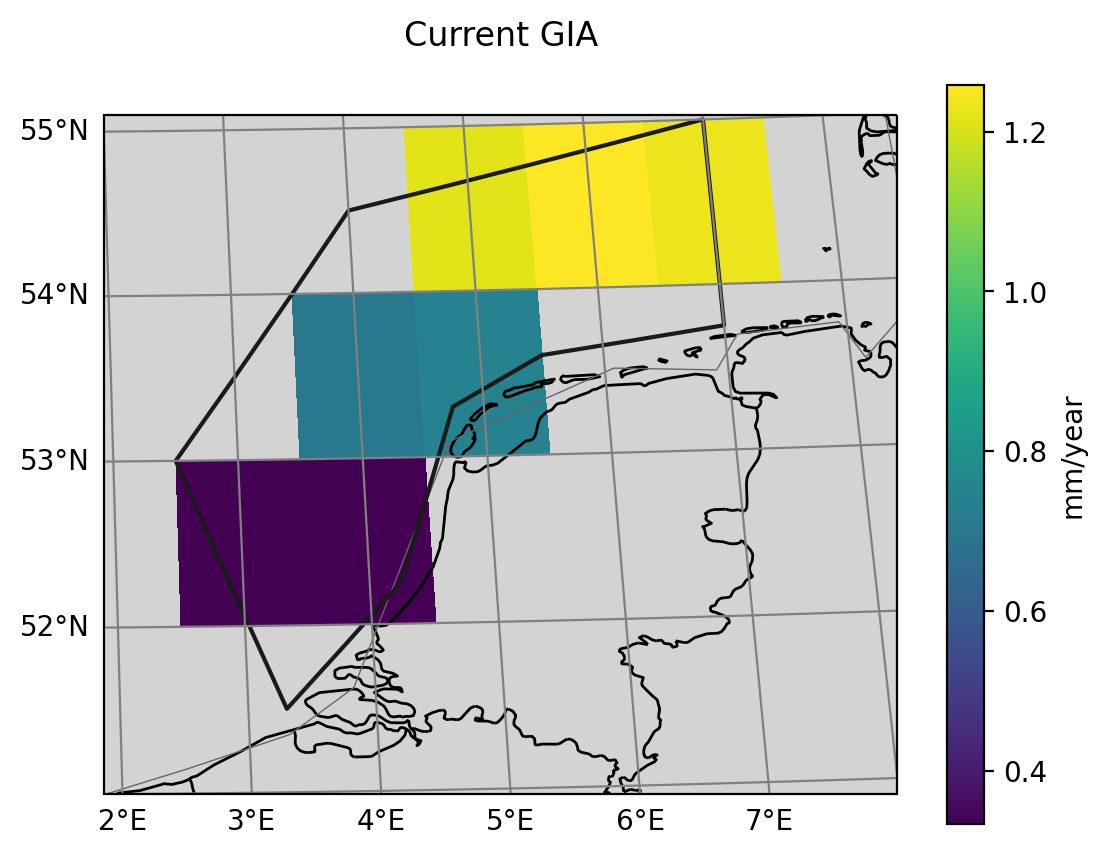

In [14]:
gia_m = gia.where(mask_ice6g)


lon_min, lon_max, lat_min, lat_max = 2, 8, 51, 55

p = gia_m.Dsea_250.sel(Lat=slice(lat_min,lat_max), Lon=slice(lon_min,lon_max) ).plot(
    subplot_kws=dict(projection=ccrs.LambertAzimuthalEqualArea(), facecolor='lightgray'), 
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'label':'mm/year'},
    #robust=True,
    zorder=0)

#p.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
p.axes.add_feature(cfeature.BORDERS)
p.axes.coastlines()

NLregion.plot(add_label=False)

gl = p.axes.gridlines(color='grey', linestyle='-', draw_labels=True)
gl.top_labels = False
gl.right_labels = False
p.axes.set_extent([lon_min, lon_max, lat_min, lat_max])
plt.title('Current GIA', pad=25)


In [15]:
# Compute the average

weights = np.cos(np.deg2rad(gia.Lat))

gia_reg_avg = gia_m.weighted(mask_ice6g * weights).mean(dim=("Lat", "Lon"))

In [16]:
gia_reg_avg

<xarray.Dataset>
Dimensions:   (region: 1)
Coordinates:
  * region    (region) int64 0
    abbrevs   (region) <U2 'NL'
    names     (region) <U2 'NL'
Data variables:
    Dsea_250  (region) float32 0.8243

### Conclusions

For now I will use 0.37 mm/yr as representing the influence of GIA on the 6 tide gauges from the ZSM.

This method will also work with other GIA models. It would be good to add other models and define an uncertainty for this process as well.

An alternative would be to define a specific region closer to the coast than the ODSL region in which to compute GIA.

## Suriname

Text(0.5, 1.0, 'Current GIA influence on RSL')

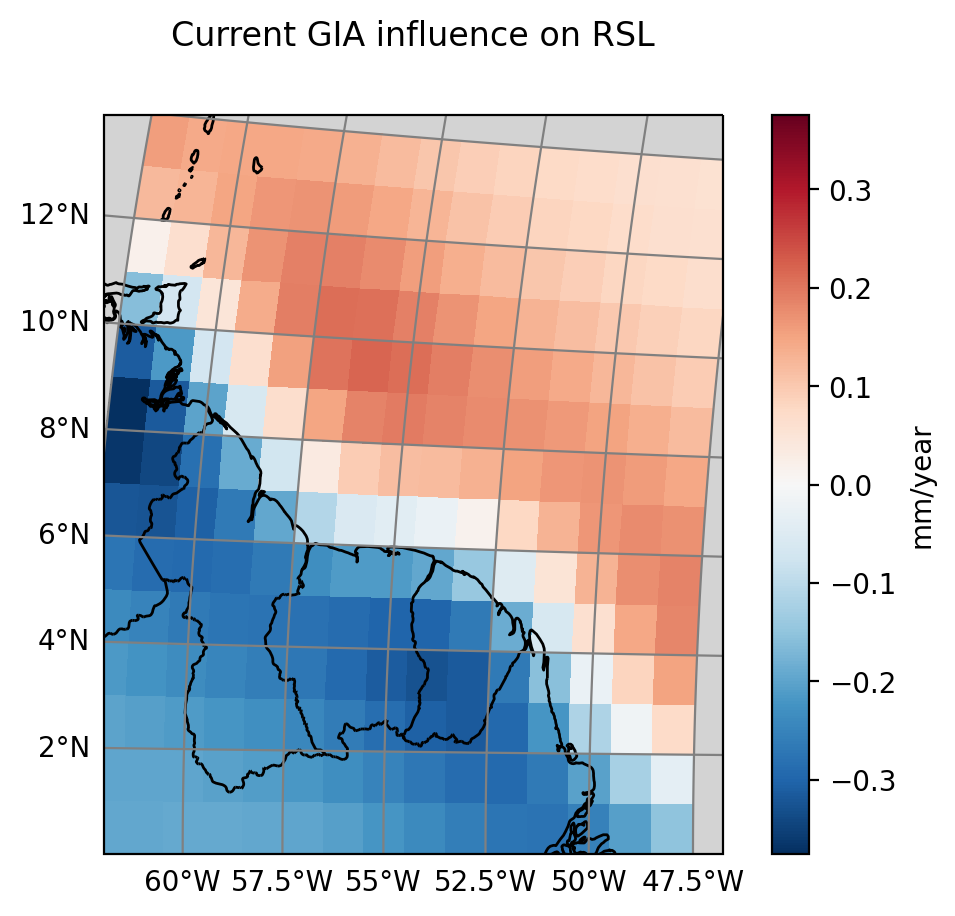

In [20]:
lon_min, lon_max, lat_min, lat_max = 360-62, 360-48, 0, 14

p = gia.Dsea_250.sel(Lat=slice(lat_min,lat_max), Lon=slice(lon_min,lon_max) ).plot(
    subplot_kws=dict(projection=ccrs.LambertAzimuthalEqualArea(), facecolor='lightgray'), 
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'label':'mm/year'},
    #robust=True,
    zorder=0)

#p.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
p.axes.add_feature(cfeature.BORDERS)
p.axes.coastlines()

#NLregion.plot(add_label=False)

gl = p.axes.gridlines(color='grey', linestyle='-', draw_labels=True)
gl.top_labels = False
gl.right_labels = False
p.axes.set_extent([lon_min, lon_max, lat_min, lat_max])
plt.title('Current GIA influence on RSL', pad=25)

Text(0.5, 1.0, 'Current GIA influence on RSL')

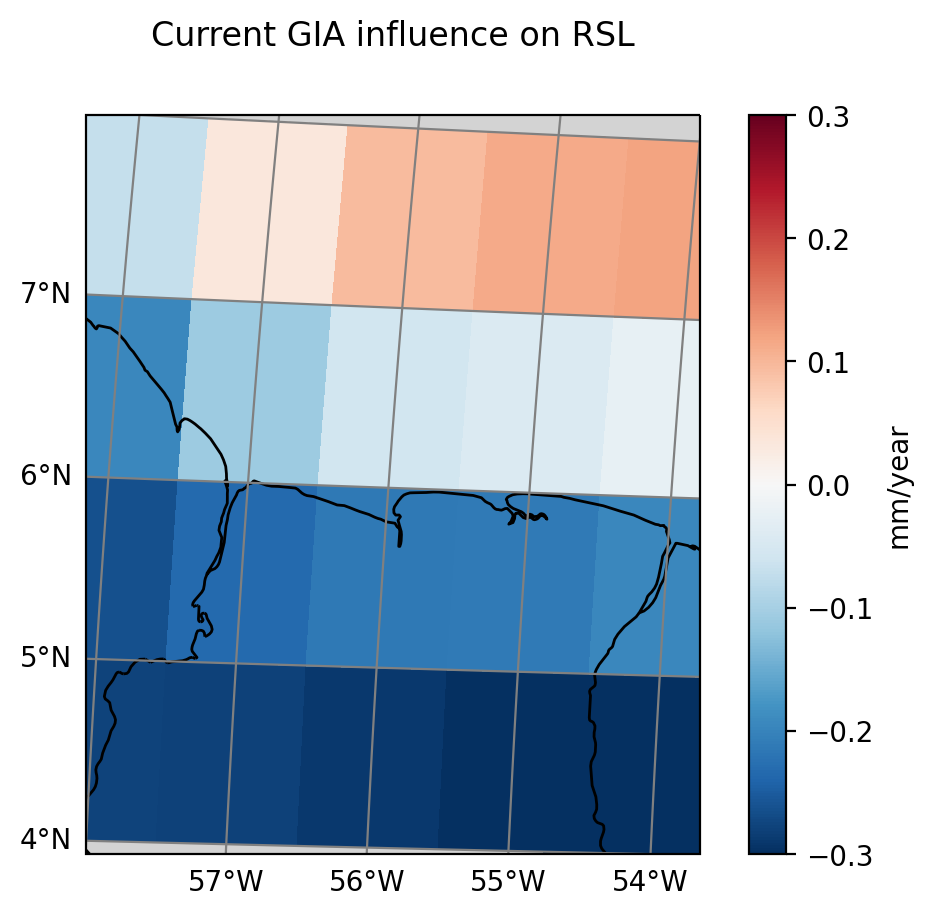

In [21]:
lon_min, lon_max, lat_min, lat_max = 360-58, 360-54, 4, 8

p = gia.Dsea_250.sel(Lat=slice(lat_min,lat_max), Lon=slice(lon_min,lon_max) ).plot(
    subplot_kws=dict(projection=ccrs.LambertAzimuthalEqualArea(), facecolor='lightgray'), 
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'label':'mm/year'},
    #robust=True,
    zorder=0)

#p.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
p.axes.add_feature(cfeature.BORDERS)
p.axes.coastlines()

#NLregion.plot(add_label=False)

gl = p.axes.gridlines(color='grey', linestyle='-', draw_labels=True)
gl.top_labels = False
gl.right_labels = False
p.axes.set_extent([lon_min, lon_max, lat_min, lat_max])
plt.title('Current GIA influence on RSL', pad=25)

There is a land uplift in Suriname. Which results in a reduction of sea level rise.